In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path

import re


from visu_utils import TASK_LIST_CLASSIFICATION, make_results_tables_per_group_size, load_classification_merged_mteb

from autorank import autorank, plot_stats, create_report, latex_table

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)

%reload_ext autoreload
%autoreload 2


In [2]:

# load mteb classification

MTEB_BASELINES_PATH = Path("../non_sync/baselines_mteb/mteb_detailed/en_Classification.csv")

RESULTS_PATHS = [Path("../non_sync/mteb_benchmarking/results/experiments_gist_nll"),
                 Path("../non_sync/mteb_benchmarking/results/experiments_gist_mse")
                 ]



df_merged = load_classification_merged_mteb(MTEB_BASELINES_PATH, RESULTS_PATHS)

df_merged = df_merged[
    (df_merged['Model Size (Million Parameters)'] >= 10) & (df_merged['Model Size (Million Parameters)'] <= 450)]

# select only last training step for each model
df_merged = df_merged.reset_index()

indices = df_merged.sort_values('Training step').groupby('Model')['Training step'].idxmax()

df_merged = df_merged.loc[indices]
df_merged = df_merged.drop('Training step', axis=1)
df_merged



,index,Model,Model Size (Million Parameters),loss,Dataset,AmazonCounterfactualClassification (en),AmazonPolarityClassification,AmazonReviewsClassification (en),Banking77Classification,EmotionClassification,ImdbClassification,MTOPDomainClassification (en),MTOPIntentClassification (en),MassiveIntentClassification (en),MassiveScenarioClassification (en),ToxicConversationsClassification,TweetSentimentExtractionClassification
29,51,Alibaba-NLP/gte-base-en-v1.5,137.0,MTEB,MTEB,74.79,93.02,53.31,86.73,46.39,87.48,96.50,82.81,77.67,81.77,83.98,61.57
28,47,Alibaba-NLP/gte-large-en-v1.5,434.0,MTEB,MTEB,73.01,93.97,54.20,87.33,46.77,92.10,96.60,82.90,78.94,81.41,82.61,63.16
67,131,Alibaba-NLP/gte-multilingual-base,305.0,MTEB,MTEB,75.96,80.72,43.64,85.36,47.95,74.91,92.54,72.58,72.13,76.28,71.03,57.60
38,70,BAAI/bge-base-en-v1.5,109.0,MTEB,MTEB,76.15,93.39,48.85,86.95,51.90,90.81,94.17,76.91,76.15,80.16,71.58,59.38
34,62,BAAI/bge-large-en-v1.5,335.0,MTEB,MTEB,75.85,92.42,48.18,87.79,51.52,92.85,94.59,79.49,77.56,80.53,70.91,59.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,225,thtang/ALL_862873,118.0,MTEB,MTEB,50.81,52.57,22.63,36.43,22.75,50.76,61.03,29.68,34.33,44.13,54.93,40.75
41,75,w601sxs/b1ade-embed,335.0,MTEB,MTEB,75.18,93.07,48.42,88.03,51.93,91.91,94.33,76.61,75.91,79.43,67.91,59.22
171,300,w601sxs/b1ade-embed-kd,335.0,MTEB,MTEB,NaN,80.30,NaN,85.19,48.22,69.87,NaN,NaN,NaN,NaN,75.01,61.80
172,301,w601sxs/b1ade-embed-kd_3,335.0,MTEB,MTEB,NaN,0.86,NaN,0.81,0.48,0.74,NaN,NaN,NaN,NaN,0.69,0.61


In [3]:
# melt columns back into rows with Accuracy
df_melted = df_merged.melt(id_vars=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'],
                           value_vars=df_merged.columns[4:], var_name='Task', value_name='Accuracy')

In [4]:
df_melted.head()

,Model,Model Size (Million Parameters),loss,Dataset,Task,Accuracy
0,Alibaba-NLP/gte-base-en-v1.5,137.0,MTEB,MTEB,AmazonCounterfactualClassification (en),74.79
1,Alibaba-NLP/gte-large-en-v1.5,434.0,MTEB,MTEB,AmazonCounterfactualClassification (en),73.01
2,Alibaba-NLP/gte-multilingual-base,305.0,MTEB,MTEB,AmazonCounterfactualClassification (en),75.96
3,BAAI/bge-base-en-v1.5,109.0,MTEB,MTEB,AmazonCounterfactualClassification (en),76.15
4,BAAI/bge-large-en-v1.5,335.0,MTEB,MTEB,AmazonCounterfactualClassification (en),75.85


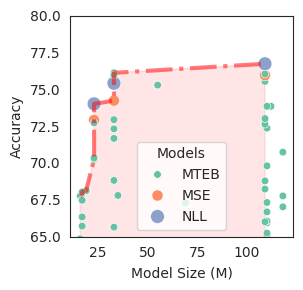

In [12]:

sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

df_avg = df_melted.groupby(['Model', 'loss']).mean(numeric_only=True)
df_avg = df_avg.reset_index()

# rename loss
df_avg['loss'] = df_avg['loss'].replace({"N/A": "MTEB"})
# rename column loss
df_avg = df_avg.rename(columns={"loss": "Models"})

# keep only less than 50M 
df_avg = df_avg[df_avg['Model Size (Million Parameters)'] <= 120]
df_avg = df_avg.dropna()

def trace_pareto_frontier(df, x, y, ax):
    df = df.sort_values(x)
    pareto_front = [df.iloc[0]]
    for i in range(1, len(df)):
        if df.iloc[i][y] >= pareto_front[-1][y]:
            pareto_front.append(df.iloc[i])
    pareto_front = pd.DataFrame(pareto_front)
    ax.plot(pareto_front[x], pareto_front[y], 'red', linestyle="-.", lw=3, alpha=0.5)
    # fill below
    ax.fill_between(pareto_front[x], pareto_front[y], 0, alpha=0.1, color='red')

trace_pareto_frontier(df_avg, 'Model Size (Million Parameters)', 'Accuracy', ax)
sns.scatterplot(data=df_avg, x='Model Size (Million Parameters)', y='Accuracy', hue='Models', size="Models",
                sizes=(100, 30), ax=ax, palette="Set2")


# move ax legend outside

sns.move_legend(ax, "lower center")

# Change label sizes
ax.set_xlabel("Model Size (M)", fontsize=10) # fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=10) #, fontweight='bold')


# set ylim
ax.set_ylim(65, 80)

# export
fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / "pareto_frontier_classification_nlp_less_110.png", dpi=500)



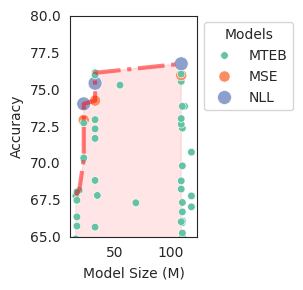

In [6]:
fig